# 7주차 실습_3

#### Denoising AE DSA
normal : lyingBack, lyingRigh

abnormal: sitting

DAE(Denoising Autoencoder)로 노이즈 데이터 디노이징하고 모델 학습 후 예측까지 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("C:/Project/DeepLearning/Data/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [3]:
df.shape

(9120, 272)

In [4]:
df['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

## Denoising AE

### 1. DSA데이터에서 lyingRigh, lyingBack(normal), sitting(abnormal)만 남기기

In [5]:
df_filtered = df[df['activity'].isin(['sitting', 'lyingRigh', 'lyingBack'])]
df_filtered = df_filtered.drop('people', axis=1)
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting


In [6]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'label' 컬럼을 숫자로 변환
df_filtered['activity'] = label_encoder.fit_transform(df_filtered['activity'])

df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,2
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,2
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,2
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,2
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,2


In [7]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 열 이름의 접두사/접미사를 사용하여 필터링
prefixes = ['T_', 'RA_', 'LA_', 'RL_', 'LL_']  # 원하는 접두사 리스
columns_to_scale = df_filtered.columns[df_filtered.columns.str.startswith(tuple(prefixes))]

# 선택한 열을 스케일링
df_filtered[columns_to_scale] = scaler.fit_transform(df_filtered[columns_to_scale])

# 스케일링 후 데이터 확인
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,1.168376,1.179659,1.134716,0.424899,1.794701,-0.037407,1.064111,1.057739,1.076760,-0.084875,...,-0.135903,-0.337940,0.344190,0.054259,0.047582,0.061705,-0.137386,-0.365251,0.185769,2
1,1.168870,1.182732,1.166896,0.154077,1.031924,0.987842,1.078602,1.065174,1.092044,-0.152909,...,-0.135459,-0.325089,-0.608202,0.053994,0.047614,0.061085,-0.137190,-0.361128,0.826319,2
2,1.167436,1.165165,1.166857,-0.022360,0.310479,0.183152,1.078626,1.065149,1.097461,-0.166074,...,-0.136085,-0.343530,-0.295205,0.054349,0.048032,0.062019,-0.137782,-0.373792,0.204012,2
3,1.161106,1.169503,1.136238,0.004198,0.442800,-0.408865,1.084727,1.091232,1.097234,-0.086558,...,-0.136242,-0.348571,0.024825,0.055501,0.049890,0.063365,-0.136432,-0.345871,0.606205,2
4,1.155360,1.173822,1.163969,-0.075787,-0.009354,3.640945,1.090312,1.076313,1.101215,-0.158700,...,-0.135700,-0.331922,-0.323528,0.056609,0.050528,0.064247,-0.137329,-0.364029,0.642770,2


In [7]:
from sklearn.preprocessing import MinMaxScaler

# StandardScaler 객체 생성
scaler = MinMaxScaler()

# 열 이름의 접두사/접미사를 사용하여 필터링
prefixes = ['T_', 'RA_', 'LA_', 'RL_', 'LL_']  # 원하는 접두사 리스
columns_to_scale = df_filtered.columns[df_filtered.columns.str.startswith(tuple(prefixes))]

# 선택한 열을 스케일링
df_filtered[columns_to_scale] = scaler.fit_transform(df_filtered[columns_to_scale])

# 스케일링 후 데이터 확인
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,0.878068,0.850020,0.867212,0.017484,0.121527,0.632119,0.936648,0.926528,0.935544,0.005484,...,0.000068,0.003517,0.443460,0.455497,0.455125,0.457179,0.000091,0.004340,0.734897,2
1,0.878241,0.851060,0.878064,0.009092,0.084417,0.692567,0.941623,0.929056,0.940740,0.001704,...,0.000092,0.004525,0.390306,0.455417,0.455135,0.456994,0.000097,0.004578,0.779254,2
2,0.877738,0.845118,0.878051,0.003625,0.049319,0.645123,0.941631,0.929047,0.942581,0.000973,...,0.000058,0.003078,0.407775,0.455524,0.455259,0.457273,0.000079,0.003849,0.736160,2
3,0.875514,0.846586,0.867726,0.004448,0.055756,0.610218,0.943726,0.937915,0.942504,0.005390,...,0.000050,0.002683,0.425636,0.455868,0.455813,0.457675,0.000120,0.005455,0.764011,2
4,0.873496,0.848046,0.877077,0.001969,0.033759,0.848993,0.945643,0.932843,0.943857,0.001383,...,0.000079,0.003989,0.406194,0.456199,0.456002,0.457939,0.000093,0.004411,0.766544,2


In [8]:
df_filtered['activity'].value_counts()

activity
2    480
0    480
1    480
Name: count, dtype: int64

#### label

0: lyingBack (normal)

1: lyingRigh (normal)

2: sitting (abnormal)

레이블을 두개로 줄여서 해보면,

0: lyingBack, lyingRigh (normal)

1: sitting (abnormal)

In [9]:
# activity가 0 또는 1인 경우 모두 0으로 통합
df_filtered.loc[df_filtered['activity'].isin([0, 1]), 'activity'] = 0
df_filtered.loc[df_filtered['activity'].isin([2]), 'activity'] = 1

In [10]:
df_filtered['activity'].value_counts()

activity
0    960
1    480
Name: count, dtype: int64

### 2. Noise Data

In [11]:
df_noised = df_filtered.copy()

noise_factor = np.random.uniform(0, 1)

# 노이즈를 추가할 열 이름의 접두사 설정
prefixes = ['T_', 'RA_', 'LA_', 'RL_', 'LL_']
columns_to_add_noise = df_noised.columns[df_noised.columns.str.startswith(tuple(prefixes))]

# 선택한 열에 노이즈 추가
for column in columns_to_add_noise:
    df_noised[column] += noise_factor * np.random.normal(loc=0.0, scale=1.0, size=df_noised[column].shape)

# 노이즈가 추가된 데이터 확인
df_noised

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,1.197857,0.550361,0.816167,-0.324550,0.085146,0.844273,1.028956,1.107716,0.435876,-0.399217,...,0.040167,-0.320902,0.080269,0.309885,0.827673,-0.030837,-0.303885,-0.304135,-0.039236,1
1,1.272144,0.687238,0.270360,0.615269,-0.275756,1.307944,0.734652,1.275250,0.794463,0.229557,...,0.491042,-0.228343,0.686113,0.335249,0.325603,0.557804,0.149949,0.533317,1.409128,1
2,0.942999,0.196186,1.012006,0.145488,0.100172,0.980550,0.178576,1.417029,1.646390,-0.316231,...,0.185607,-0.180559,0.226499,0.695629,0.626101,0.371767,0.165170,-0.181826,0.673833,1
3,1.173616,0.868095,0.694904,-0.499236,0.151264,0.817355,1.088145,1.385123,0.553357,0.289387,...,0.316209,0.759310,0.259335,0.326129,0.106640,0.771787,-0.226945,0.029468,0.280296,1
4,0.171522,0.687635,0.815821,-0.769131,-0.282511,0.701445,1.159576,1.023366,0.699305,0.208766,...,-0.092986,-0.390363,0.355720,0.837684,-0.183725,1.429665,-0.682878,0.257787,0.831784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,0.874152,0.284176,0.439280,0.081366,-0.348154,0.559489,-0.212518,0.292948,0.042148,0.553666,...,0.096725,-0.292618,0.507457,0.242458,0.034375,0.377867,-0.188222,0.247647,0.656820,0
1916,0.935424,0.435396,0.371412,0.033244,-0.266393,0.931472,-0.044482,0.177498,-0.500858,-0.226348,...,-0.497609,-0.008458,0.257085,0.880424,0.270670,-0.355283,-0.066378,0.518280,1.215228,0
1917,0.902386,0.630779,0.106847,-0.124378,0.418291,0.775431,-0.499300,-0.115054,-0.761068,-0.666921,...,-0.157169,0.003046,0.774296,0.161070,-0.062832,-0.025478,0.056078,0.473528,0.506153,0
1918,1.090265,0.491112,0.853918,0.376438,0.204261,0.159685,0.288006,0.247952,0.244628,-0.221540,...,-0.187879,0.452630,0.651949,0.250204,0.297353,-0.085303,-0.327791,0.171686,0.481403,0


In [12]:
# normal = df_filtered[(df_filtered.activity == 0)

normal = df_filtered[(df_noised.activity == 0)]

# activity가 1인 데이터를 선택
abnormal = df_filtered[df_noised.activity == 1]

# normal 데이터프레임의 모양 확인
normal.shape

(960, 271)

In [13]:
abnormal.shape

(480, 271)

### 2. Denoising AutoEncoder model


노이즈가 낀 데이터를 입력으로, 정상 데이터를 출력으로 정하여 Denoising을 학습시켜보자.

In [14]:
# 노이즈가 낀 데이터와 노이즈가 없는 데이터

noisy_train = df_noised.drop(['activity'], axis=1)

pure_train = df_filtered.drop(['activity'], axis=1)

In [15]:
# 오토인코더 모델

input_dim = noisy_train.shape[1]
encoding_dim = 16  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 270)]             0         
                                                                 
 dense (Dense)               (None, 16)                4336      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 270)               4590      
                                                                 
Total params: 9206 (35.96 KB)
Trainable params: 9206 (35.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Denoising 학습

- verbose=0: 출력 없음
- verbose=1: 각 epoch마다 학습 진행 상황을 출력
- verbose=2: 각 epoch마다 간략한 진행 상황을 출력

In [33]:
# verbose 값이 0
autoencoder.fit(noisy_train, pure_train, epochs=200, batch_size=256, shuffle=True, verbose=1)

Epoch 1/200
6/6 [==============================] - 1s 3ms/step - loss: 0.0167
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 4/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 5/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 6/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 7/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 8/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0152
Epoch 9/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 11/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 12/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0140
Epoch 13/200
6/6 [==============================] - 0s 3ms/st

In [34]:
from sklearn.model_selection import train_test_split

X_noisy_train, X_noisy_test = train_test_split(df_noised, test_size=0.25, random_state=20)

X_noisy_test.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
1107,0.231280,0.236443,-0.582461,-0.065109,0.251118,0.403467,1.434963,1.240426,0.870512,0.525440,...,-0.172554,0.118003,0.216997,0.917942,1.056017,0.713660,0.196411,-0.058119,0.428457,0
1383,0.094446,0.102331,0.890317,-0.074592,-0.208329,-0.313868,0.809839,0.322750,0.617377,-0.606446,...,-0.090098,0.030562,0.721349,0.168812,-0.104230,-0.169602,0.221783,0.074562,0.855268,0
1231,-0.181684,0.022964,0.035407,0.204294,0.416931,0.515060,0.932552,0.755220,1.226010,0.497636,...,-0.216067,-0.045655,1.049270,1.059971,0.603047,1.055823,-0.098474,0.018850,1.110031,0
420,1.060323,0.932135,0.637651,0.445772,0.001278,0.852666,1.132859,0.969980,1.022396,0.160560,...,0.202072,-0.178063,0.150560,1.060624,0.905288,0.441407,-0.242392,-0.515693,1.168965,1
321,1.164200,0.692719,0.816166,0.137999,-0.243305,0.749677,0.483206,0.412769,0.346343,0.085004,...,-0.283007,-0.944846,0.803677,1.005163,0.443834,0.793674,-0.568227,-0.088370,0.954598,1


In [35]:
# normal feature만 가지는 X_train
# 0: normal, 1: abnormal
X_noisy_train = X_noisy_train[X_noisy_train.activity == 0]

y_train = X_noisy_train['activity']
y_test = X_noisy_test['activity']

X_noisy_train = X_noisy_train.drop(['activity'], axis=1)
X_noisy_test = X_noisy_test.drop(['activity'], axis=1)

X_noisy_train.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
1010,-0.450883,0.713635,-0.399866,-0.022596,0.305509,0.621548,0.533946,0.369037,0.955093,0.684917,...,0.318442,-0.231307,-0.232725,0.520349,0.263759,0.341403,0.789725,0.915480,-0.146494,0.584480
1467,0.682244,0.366016,0.742998,0.476180,0.196833,0.617836,0.297896,-0.090829,0.325522,-0.042871,...,0.002540,0.325236,-0.213251,0.345358,0.265633,0.198526,0.640289,0.101956,0.130811,1.142867
962,-0.069312,-0.113229,0.198924,0.012134,0.440799,0.534420,0.544103,0.953377,0.344954,0.010374,...,0.913899,-0.574115,0.320937,0.198501,0.378887,-0.177786,0.172263,0.101323,-0.173580,0.544748
1691,0.387139,0.304438,0.537566,-0.023642,-0.201265,0.279249,-0.096258,0.446437,-0.231851,-0.085783,...,0.095183,0.829138,0.226642,0.161310,0.820296,0.086874,-0.148126,0.283510,0.320070,0.675401
1721,0.057502,0.402458,0.514233,0.073113,-0.120249,0.190988,-0.022578,-0.314565,0.773140,-0.403597,...,0.727151,0.577540,0.368001,0.201331,0.799564,0.038345,0.265427,0.364887,0.085506,1.005403


In [36]:
X_noisy_test.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
1107,0.231280,0.236443,-0.582461,-0.065109,0.251118,0.403467,1.434963,1.240426,0.870512,0.525440,...,0.123678,-0.172554,0.118003,0.216997,0.917942,1.056017,0.713660,0.196411,-0.058119,0.428457
1383,0.094446,0.102331,0.890317,-0.074592,-0.208329,-0.313868,0.809839,0.322750,0.617377,-0.606446,...,0.933743,-0.090098,0.030562,0.721349,0.168812,-0.104230,-0.169602,0.221783,0.074562,0.855268
1231,-0.181684,0.022964,0.035407,0.204294,0.416931,0.515060,0.932552,0.755220,1.226010,0.497636,...,0.315592,-0.216067,-0.045655,1.049270,1.059971,0.603047,1.055823,-0.098474,0.018850,1.110031
420,1.060323,0.932135,0.637651,0.445772,0.001278,0.852666,1.132859,0.969980,1.022396,0.160560,...,0.444869,0.202072,-0.178063,0.150560,1.060624,0.905288,0.441407,-0.242392,-0.515693,1.168965
321,1.164200,0.692719,0.816166,0.137999,-0.243305,0.749677,0.483206,0.412769,0.346343,0.085004,...,0.926362,-0.283007,-0.944846,0.803677,1.005163,0.443834,0.793674,-0.568227,-0.088370,0.954598


In [37]:
X_noisy_train.shape, X_noisy_test.shape

((728, 270), (360, 270))

## 3. 만들어진 DAE로 노이즈 없애기

In [38]:
denoised_X_train = autoencoder.predict(X_noisy_train)
denoised_X_test = autoencoder.predict(X_noisy_test)

12/12 [==============================] - 0s 2ms/step


In [39]:
# denoised_X_train를 pandas DataFrame으로 변환
denoised_X_train = pd.DataFrame(denoised_X_train, columns=pure_train.columns) 
denoised_X_train.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
0,0.128166,0.101945,0.143008,0.000174,0.016686,0.642078,0.775655,0.762334,0.770948,0.000371,...,0.708529,0.000217,0.005748,0.419678,0.205161,0.202045,0.203462,0.001410,0.014694,0.737889
1,0.435370,0.424896,0.457737,0.004084,0.035458,0.610346,0.119990,0.118294,0.106011,0.009597,...,0.656292,0.004716,0.023010,0.423954,0.146837,0.148987,0.152840,0.015309,0.021865,0.689233
2,0.088231,0.075039,0.103227,0.000120,0.016349,0.647208,0.837287,0.827847,0.842880,0.000227,...,0.708362,0.000170,0.004622,0.422441,0.216797,0.219767,0.218581,0.000930,0.012092,0.742459
3,0.568358,0.498331,0.571911,0.000392,0.003420,0.627176,0.013965,0.012232,0.009522,0.004101,...,0.251526,0.000288,0.015313,0.401669,0.190239,0.169281,0.177681,0.002888,0.005638,0.744641
4,0.509553,0.450221,0.518709,0.000267,0.002434,0.632500,0.007591,0.006568,0.005301,0.003279,...,0.119506,0.000134,0.017334,0.402183,0.173757,0.157811,0.162561,0.002072,0.005464,0.750517


In [40]:
# denoised_X_test를 pandas DataFrame으로 변환
denoised_X_test = pd.DataFrame(denoised_X_test, columns=pure_train.columns) 
denoised_X_test.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
0,0.054156,0.045369,0.059179,0.009850,0.064507,0.602253,0.844364,0.829724,0.827541,0.012607,...,0.575708,0.038361,0.101492,0.456030,0.820886,0.817260,0.817502,0.016642,0.051112,0.654307
1,0.190514,0.168156,0.213529,0.000373,0.032011,0.638464,0.813495,0.808212,0.822982,0.000720,...,0.710286,0.000424,0.008678,0.427348,0.207838,0.216661,0.214034,0.002371,0.024875,0.721918
2,0.137013,0.106611,0.149376,0.000305,0.015217,0.636267,0.857035,0.841379,0.845101,0.001024,...,0.608475,0.000804,0.015155,0.430744,0.651035,0.637449,0.638850,0.001481,0.014046,0.728606
3,0.969578,0.950378,0.965427,0.002330,0.046075,0.622346,0.853642,0.842999,0.832693,0.046376,...,0.508877,0.003106,0.105827,0.434330,0.874195,0.866470,0.865735,0.009169,0.094062,0.699178
4,0.805955,0.746854,0.805370,0.000737,0.036039,0.633157,0.800736,0.792656,0.794164,0.005341,...,0.609683,0.000717,0.026378,0.426996,0.487888,0.487063,0.484155,0.004304,0.049492,0.716290


### 4. Denoised data Autoencoding model

디노이즈한 denoised_X_test로 activity 예측 오토인코더 모델을 학습시킨 후 성능확인을 해보자.

검증 데이터로 df_filtered을 사용한다.

In [41]:
from sklearn.model_selection import train_test_split

X_pure_train, X_pure_test = train_test_split(df_filtered, test_size=0.25, random_state=20)

X_pure_train = X_pure_train[X_pure_train.activity == 0]
X_pure_train = X_pure_train.drop(['activity'], axis=1)
X_pure_test = X_pure_test.drop(['activity'], axis=1)

In [42]:
# 오토인코더 모델

input_dim = denoised_X_train.shape[1]
encoding_dim = 16  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim/2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 270)]             0         
                                                                 
 dense_8 (Dense)             (None, 16)                4336      
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dense_11 (Dense)            (None, 270)               2430      
                                                                 
Total params: 6974 (27.24 KB)
Trainable params: 6974 (27.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
denoised_X_test.shape

(360, 270)

In [60]:
# 모델 학습
history = autoencoder.fit(denoised_X_train, denoised_X_train, epochs=800, batch_size=256, shuffle=True, validation_split = 0.1)

Epoch 1/800
3/3 [==============================] - 0s 55ms/step - loss: 3.8516e-04 - val_loss: 4.0065e-04
Epoch 2/800
3/3 [==============================] - 0s 24ms/step - loss: 3.8455e-04 - val_loss: 3.9911e-04
Epoch 3/800
3/3 [==============================] - 0s 20ms/step - loss: 3.8548e-04 - val_loss: 3.9720e-04
Epoch 4/800
3/3 [==============================] - 0s 21ms/step - loss: 3.8343e-04 - val_loss: 4.0072e-04
Epoch 5/800
3/3 [==============================] - 0s 21ms/step - loss: 3.8455e-04 - val_loss: 3.9986e-04
Epoch 6/800
3/3 [==============================] - 0s 22ms/step - loss: 3.8484e-04 - val_loss: 3.9612e-04
Epoch 7/800
3/3 [==============================] - 0s 21ms/step - loss: 3.8318e-04 - val_loss: 3.9847e-04
Epoch 8/800
3/3 [==============================] - 0s 23ms/step - loss: 3.8367e-04 - val_loss: 3.9676e-04
Epoch 9/800
3/3 [==============================] - 0s 21ms/step - loss: 3.8404e-04 - val_loss: 3.9631e-04
Epoch 10/800
3/3 [============================

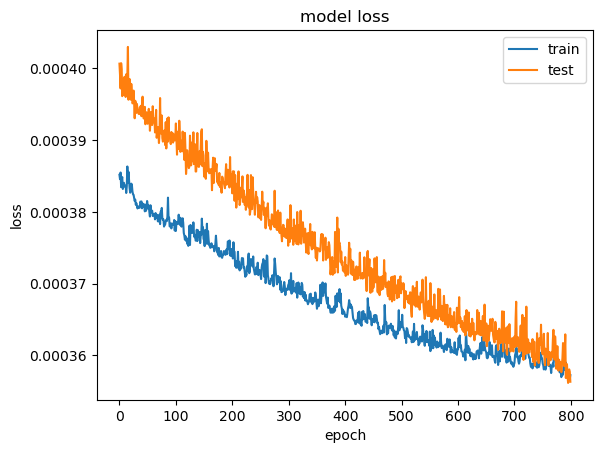

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Noisy 데이터로 AE 예측

In [62]:
# X_noisy_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_noisy_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_noisy_test)
mse = np.mean(np.power(X_noisy_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

12/12 [==============================] - 0s 2ms/step


,reconstruction_error,true_class
count,360.000000,360.000000
mean,0.145062,0.355556
std,0.020130,0.479348
min,0.105987,0.000000
25%,0.130566,0.000000
50%,0.143511,0.000000
75%,0.155010,1.000000
max,0.240056,1.000000


In [63]:
error_df = error_df.reset_index(drop=True)
error_df

,reconstruction_error,true_class
0,0.124728,0
1,0.127389,0
2,0.120539,0
3,0.141001,1
4,0.148672,1
...,...,...
355,0.139288,0
356,0.138439,1
357,0.131157,0
358,0.150462,1


In [64]:
threshold = 0.13

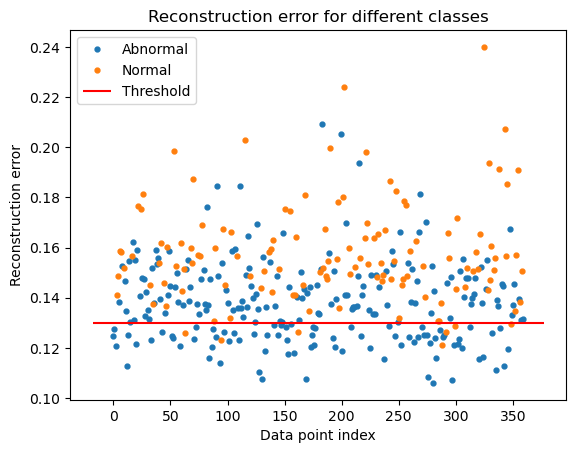

In [65]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Abnormal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [66]:
LABELS = ["Normal", "Abnormal"]

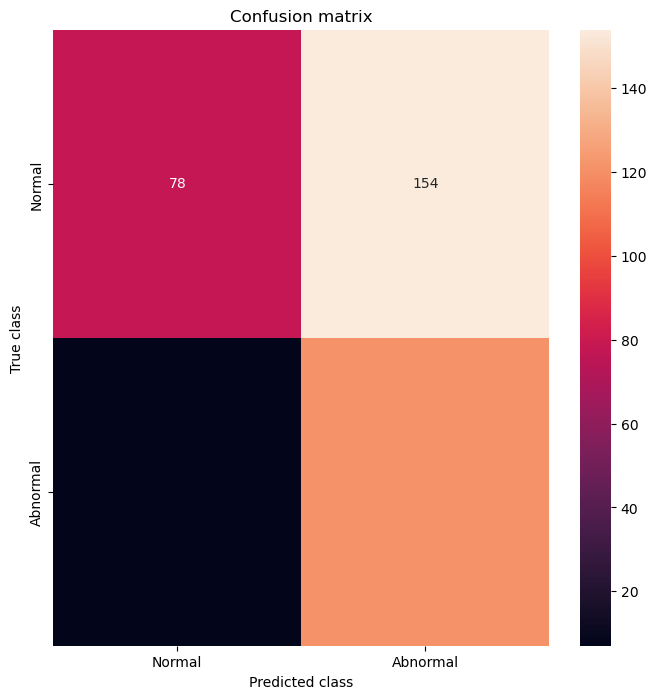

              precision    recall  f1-score   support

           0       0.92      0.34      0.49       232
           1       0.44      0.95      0.60       128

    accuracy                           0.55       360
   macro avg       0.68      0.64      0.55       360
weighted avg       0.75      0.55      0.53       360



In [67]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))